Library import and data plot

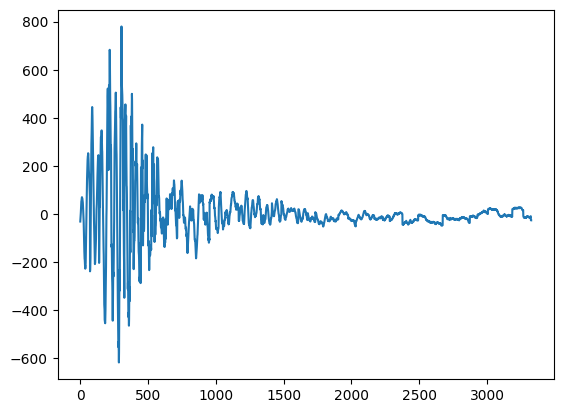

1700609


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

fs = 3327/59

folder = 'data_set/'
file_name = 'bring.txt'

samples_per_record = int (3327)
start= 0

data = np.loadtxt(folder+file_name)
end = start + samples_per_record*1

idx = range(len(data[start:end]))
idx
plt.plot(idx,data[start:end],'-')
plt.show()
print(len(data))


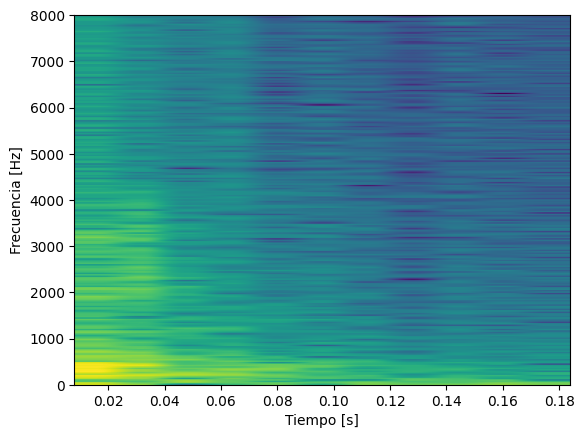

(257, 11)


In [45]:
# Definir los parámetros para el espectrograma
num = 128*4
win = np.hamming(num)
nfft = num
hop = nfft // 2
fs = 16000

# Constants from the data set adquisition
time_per_sample = 2
samples_per_record = int (3327)


# Calcular el espectrograma
# spec, freqs, times, _ = plt.specgram(data, NFFT=nfft, Fs=fs, window=win, noverlap=hop)
spec, freqs, times, _ = plt.specgram(data[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop)



# Representar gráficamente el espectrograma
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.show()
print(spec.shape)


In [34]:
import numpy as np

# Definir los parámetros para el espectrograma
num = 512  # Tamaño del segmento de tiempo
win = np.hamming(num)  # Ventana de Hamming
nfft = num  # Tamaño de la FFT (igual al tamaño del segmento de tiempo)
hop = nfft // 2  # Superposición de segmentos (la mitad del tamaño del segmento)
fs = 16000  # Frecuencia de muestreo

# Tamaño de la señal de audio y cálculo del número de segmentos de tiempo
signal_length = 3327
time_per_sample = 2.5 / signal_length  # Tiempo por punto de datos
samples_per_record = signal_length

# Cálculo del número de segmentos de tiempo
num_frames = (signal_length - num) // hop + 1

# Cálculo del tamaño del espectrograma
spec_shape = (nfft // 2 + 1, num_frames)
print("Tamaño del espectrograma:", spec_shape)


Tamaño del espectrograma: (257, 11)


Data parse

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

samples_per_record = int (3327)
fs = 3327/59

print(f"TensorFlow version = {tf.__version__}\n")

# List of commands that the nn will recognize
commands = ['now', 'take','fetch','noise','cancel','driver','pillow','slider','rod','stop','wrench','piston','crank']

# Constants from the data set adquisition
# time_per_sample = 2
# samples_per_record = int (3327/3)

num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

inputs = []
outputs = []

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    # print(i*samples_per_record)
    # print()
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    plt.close()
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")



TensorFlow version = 2.12.0

Processing index 0 for command 'now'.
	There are 115 recordings of the now command.
Processing index 1 for command 'take'.
	There are 108 recordings of the take command.
Processing index 2 for command 'fetch'.
	There are 110 recordings of the fetch command.
Processing index 3 for command 'noise'.
	There are 105 recordings of the noise command.
Processing index 4 for command 'cancel'.
	There are 109 recordings of the cancel command.
Processing index 5 for command 'driver'.
	There are 103 recordings of the driver command.
Processing index 6 for command 'pillow'.
	There are 101 recordings of the pillow command.
Processing index 7 for command 'slider'.
	There are 121 recordings of the slider command.
Processing index 8 for command 'rod'.
	There are 100 recordings of the rod command.
Processing index 9 for command 'stop'.
	There are 100 recordings of the stop command.
Processing index 10 for command 'wrench'.
	There are 110 recordings of the wrench command.
Proc

Randomize samples

In [4]:
# Sort inputs randomly
num_inputs = len(inputs)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs = inputs[random_idx]
outputs = outputs[random_idx]

# Split the inputs into: training (60%), testing(20%) and validation(20%)
train_idx = int(0.6 * num_inputs)
test_idx = int(0.2 * num_inputs + train_idx)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [train_idx, test_idx])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [train_idx, test_idx])

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [5]:
# build the model and train it

# Define the input shape
input_shape = inputs_train[1].shape

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 32
filter_size_layer_1 = (3,3)
model = 0
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# optimizer= adam loss= crossentropy metrics = accuracy
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.3, momentum=0.2), loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=50, batch_size=10, validation_data=(inputs_validate, outputs_validate))

2023-05-10 10:32:17.148782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


KeyboardInterrupt: 

Loss graph

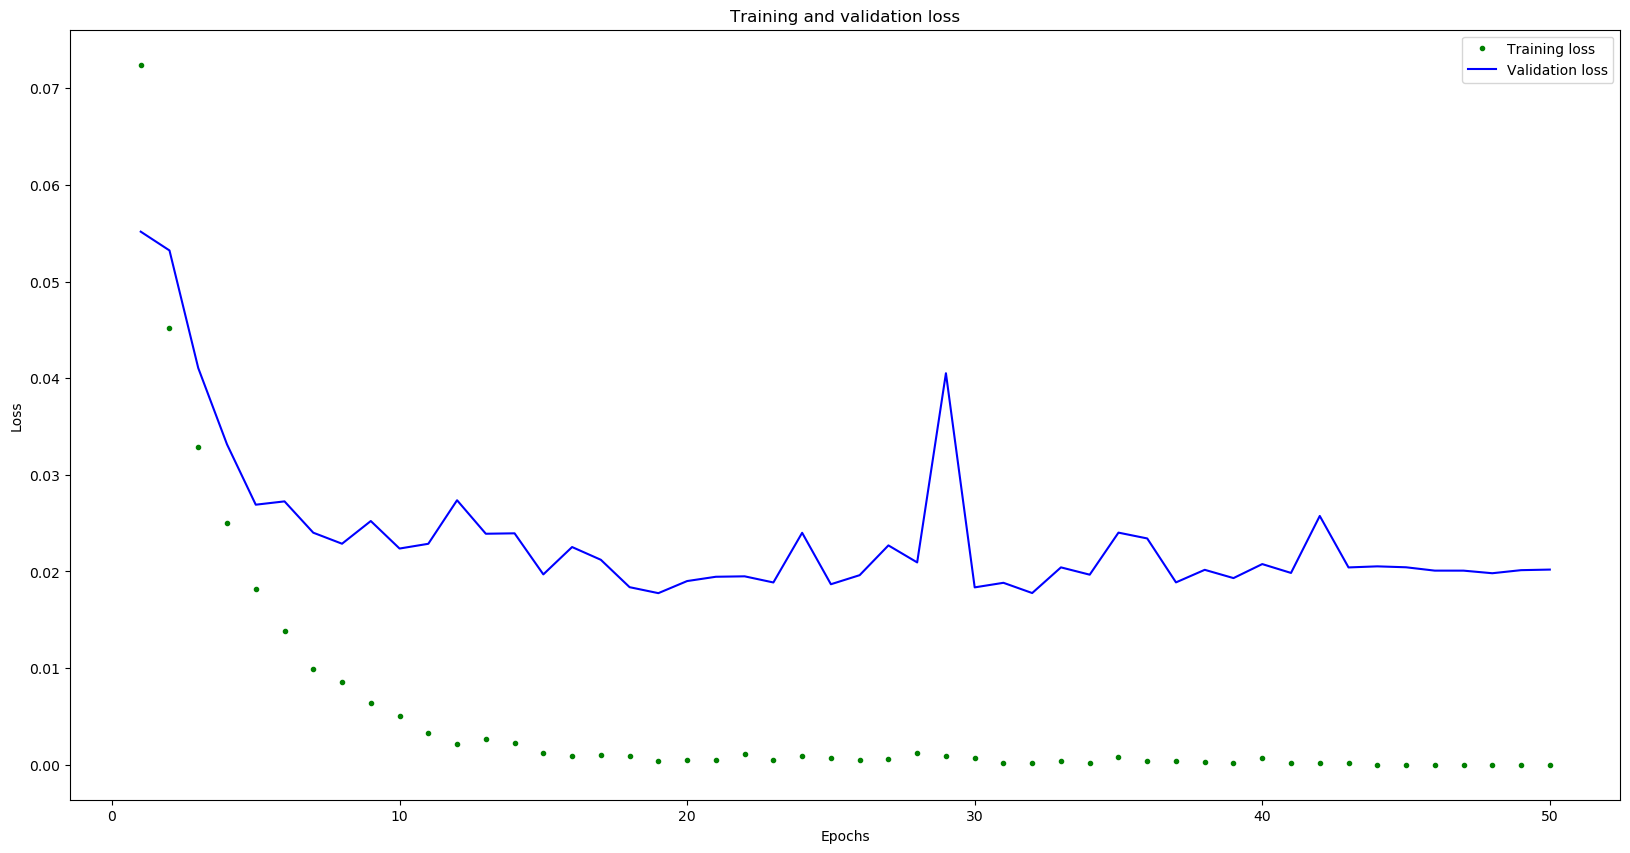

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

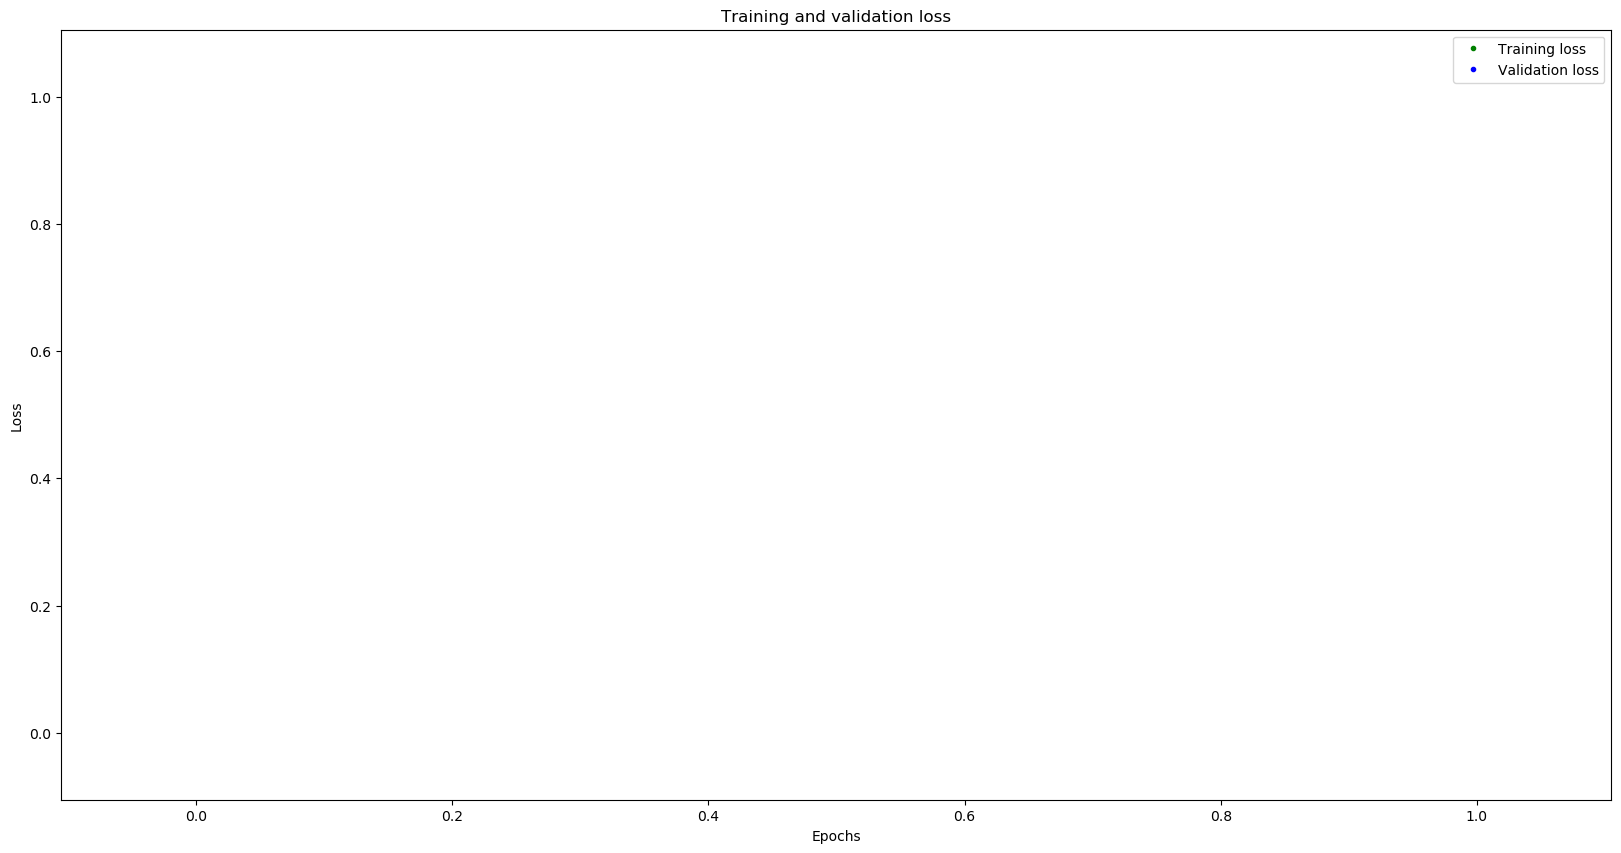

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Mean absolute error graph

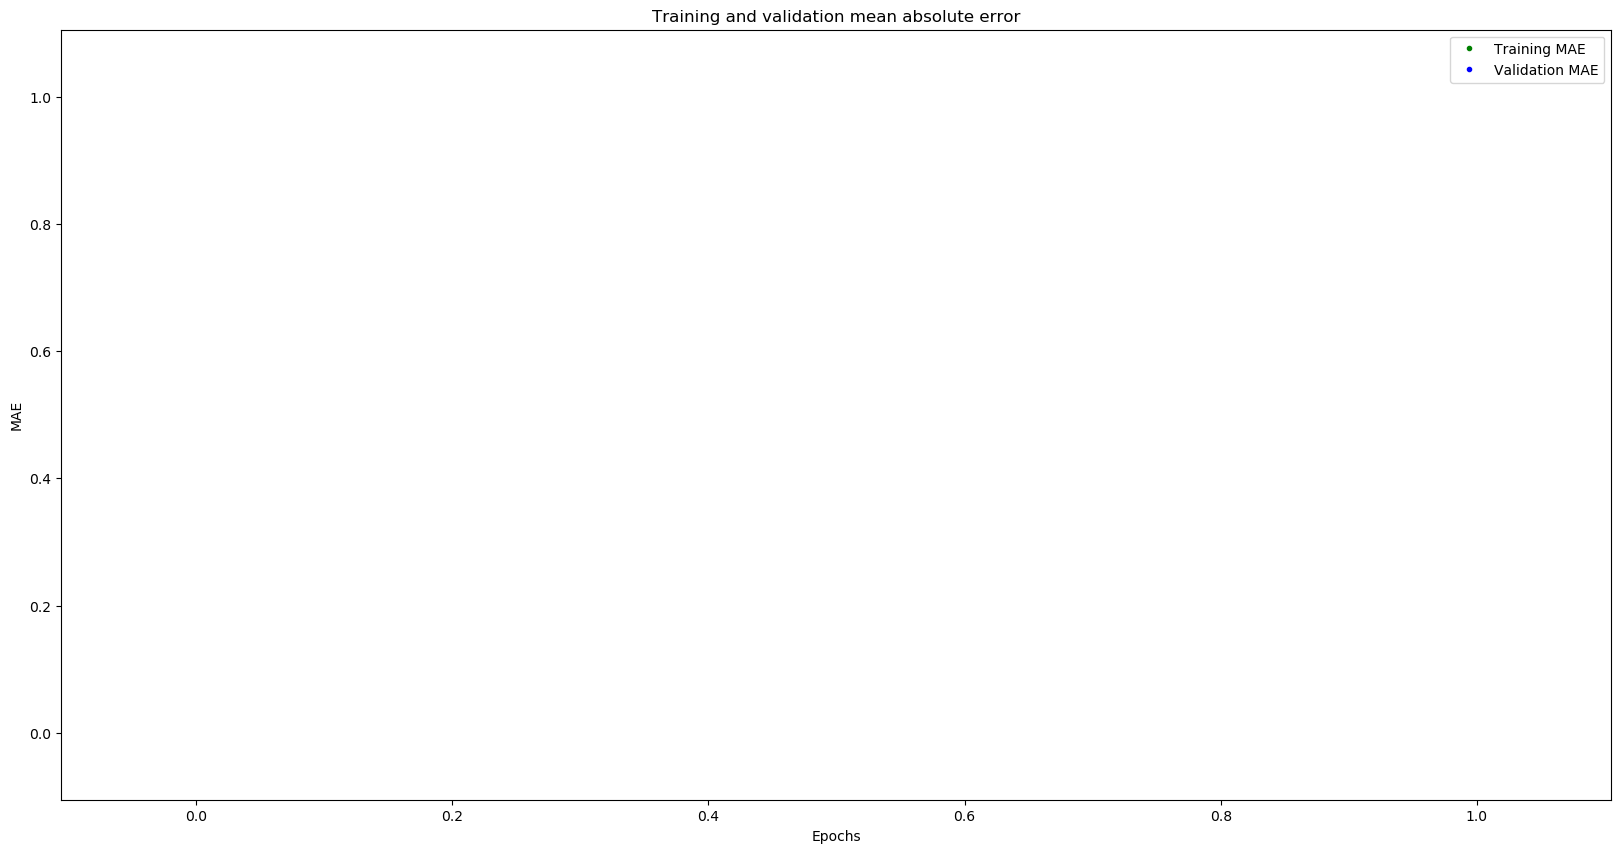

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [ ]:
print(outputs_test.shape)
len((outputs_test[1]))

(277, 13)


13

Test model predictions

9/9 [==============================] - 0s 1ms/step
class: 13
[[17.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  3. 15.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 22.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0. 23.  0.  0.  0.  0.  0.  0.  2.  0.]
 [ 0.  0.  1.  0.  1. 15.  1.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  1. 24.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  4.  3.  0. 14.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  7.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 12. 13.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 20.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 22.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2. 10.]]


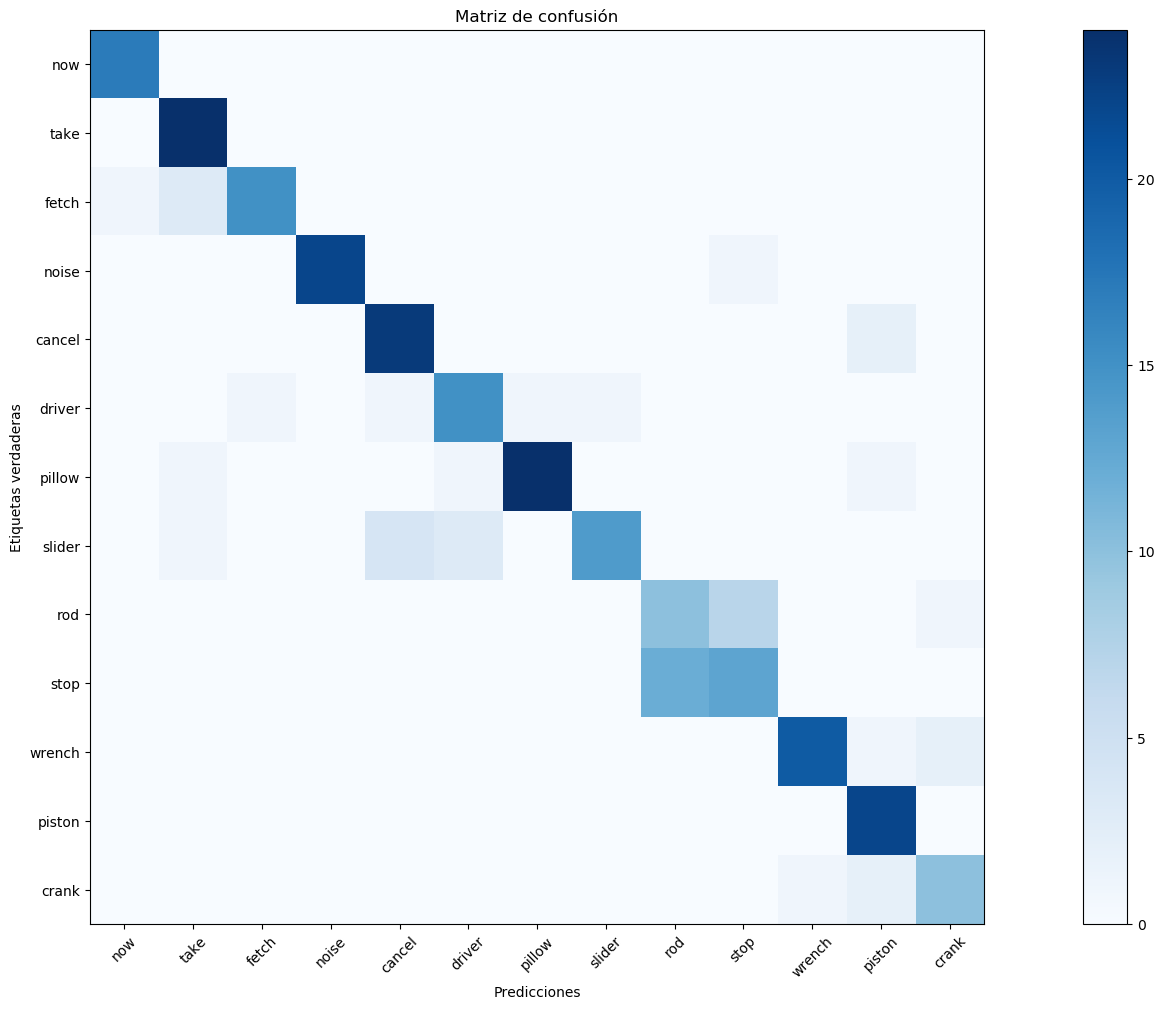

In [ ]:
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

import numpy as np
import matplotlib.pyplot as plt

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    # print(predicted_class)
    # print(true_class)
    confusion_matrix[true_class][predicted_class] += 1

print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()



# for i in range(len(predictions)):
#     # print the predictions and the expected ouputs
#     print("predictions =\n", np.round(predictions[i]))
#     print("actual =\n", outputs_test[i])


Convert model to tensorflow lite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("command_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpz300bejh/assets


INFO:tensorflow:Assets written to: /tmp/tmpz300bejh/assets


Model is 2111560 bytes


2023-05-08 12:57:06.072895: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-08 12:57:06.072926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-08 12:57:06.073171: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz300bejh
2023-05-08 12:57:06.074062: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-08 12:57:06.074076: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz300bejh
2023-05-08 12:57:06.076865: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-05-08 12:57:06.107931: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpz300bejh
2023-05-08 12:57:06.113029: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 39860 m